<a href="https://colab.research.google.com/github/LDJWJ/00_GoogldCloud_Study/blob/master/ch09_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 콜랩환경에서 훈련을 해 보기
* 사전 작업 : test01.csv와 train01.csv의 구글 드라이브에 업로드가 필요하다.
* 구글 콜랩에서 '구글 드라이브 마운트' 해주기
* 사용 데이터 셋은 train01, test01만을 우선 이용
* 여기에서 구글 드라이브 업로드 장소를 아래와 같이 하였다. 
  * /00_dataset/00_gc_ch09


In [1]:
# 구글 드라이브 데이터 셋 확인
!ls -l drive/'My Drive'/00_dataset/00_gc_ch09

total 384470
-rw------- 1 root root       151 Mar 17 04:56 '데이터 설명.gdoc'
-rw------- 1 root root 112591808 Mar 17 04:49  test01.csv
-rw------- 1 root root 281104675 Mar 17 05:10  train01.csv


In [2]:
# 데이터 복사
!mkdir gc_data
!cp drive/'My Drive'/00_dataset/00_gc_ch09/test*.csv /content/gc_data
!cp drive/'My Drive'/00_dataset/00_gc_ch09/train*.csv /content/gc_data
!ls -l /content/gc_data

total 384484
-rw------- 1 root root 112591808 Mar 17 05:11 test01.csv
-rw------- 1 root root 281104675 Mar 17 05:11 train01.csv


In [0]:
!ls -l /content/gc_data

In [3]:
# page 439, # model.py
# flights_model_tf2.ipynb 파일 참조
# 텐서플로워 패키지 임포트, csv 파일 헤더 정의
%tensorflow_version 2.x 
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
CSV_COLUMNS  = ('ontime,dep_delay,taxiout,distance,avg_dep_delay,avg_arr_delay' + \
                ',carrier,dep_lat,dep_lon,arr_lat,arr_lon,origin,dest').split(',')
LABEL_COLUMN = 'ontime'

In [5]:
print(len(CSV_COLUMNS))   # 13개의 컬럼
print(CSV_COLUMNS)

13
['ontime', 'dep_delay', 'taxiout', 'distance', 'avg_dep_delay', 'avg_arr_delay', 'carrier', 'dep_lat', 'dep_lon', 'arr_lat', 'arr_lon', 'origin', 'dest']


In [0]:
# 컬럼값이 비어 있을 경우, 기본값을 지정
DEFAULTS     = [[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],\
                ['na'],[0.0],[0.0],[0.0],[0.0],['na'],['na']]

### 아래 내용의 함수 선언(read_dataset)
 * 훈련 데이터를 읽고, 
 * batch_siz 표본을 생성
 * 전체 훈련 셋의 num_training_epochs 시간 수행

```
def load_dataset(pattern, batch_size=1):
  return tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
```

In [0]:
def load_dataset(pattern, batch_size=1):
  return tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)

### 데이터 읽기
def features_and_labels(features):
  label = features.pop('ontime') # this is what we will train for
  return features, label

# pattern : 파일 경로
# batch_size : 
# truncate : 
def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = load_dataset(pattern, batch_size)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset

In [0]:
DEVELOP_MODE = True  # 개발자 모드

In [0]:
TRAIN_DATA_PATTERN = '/content/gc_data/' + "train01*"   # 학습용 데이터 셋
EVAL_DATA_PATTERN = '/content/gc_data/' + "test01*"     # 평가용 데이터 셋

```
if DEVELOP_MODE:
    dataset = load_dataset(TRAIN_DATA_PATTERN)
    for n, data in enumerate(dataset):
        numpy_data = {k: v.numpy() for k, v in data.items()} # .numpy() works only in eager mode
        print(numpy_data)
        if n>3: break
```

In [18]:
if DEVELOP_MODE:
    dataset = load_dataset(TRAIN_DATA_PATTERN)
    for n, data in enumerate(dataset):
        numpy_data = {k: v.numpy() for k, v in data.items()} # .numpy() works only in eager mode
        print(numpy_data)
        if n>3: break

{'ontime': array([1.], dtype=float32), 'dep_delay': array([-3.], dtype=float32), 'taxiout': array([9.], dtype=float32), 'distance': array([153.], dtype=float32), 'avg_dep_delay': array([28.206839], dtype=float32), 'avg_arr_delay': array([-12.], dtype=float32), 'carrier': array([b'EV'], dtype=object), 'dep_lat': array([33.636665], dtype=float32), 'dep_lon': array([-84.42778], dtype=float32), 'arr_lat': array([34.895557], dtype=float32), 'arr_lon': array([-82.21889], dtype=float32), 'origin': array([b'ATL'], dtype=object), 'dest': array([b'GSP'], dtype=object)}
{'ontime': array([1.], dtype=float32), 'dep_delay': array([-7.], dtype=float32), 'taxiout': array([23.], dtype=float32), 'distance': array([150.], dtype=float32), 'avg_dep_delay': array([24.01855], dtype=float32), 'avg_arr_delay': array([1.], dtype=float32), 'carrier': array([b'OO'], dtype=object), 'dep_lat': array([40.788334], dtype=float32), 'dep_lon': array([-111.977776], dtype=float32), 'arr_lat': array([42.90972], dtype=float

### 입력 데이터 파이프 라인 만들기
```
DATA_BUCKET = "gs://{}/flights/chapter8/output/".format(BUCKET)
TRAIN_DATA_PATTERN = DATA_BUCKET + "train*"
EVAL_DATA_PATTERN = DATA_BUCKET + "test*"
```

```
if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(TRAIN_DATA_PATTERN, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items
```

In [16]:
### 데이터 읽어오기
if DEVELOP_MODE:
    print("입력 파이프라인 체크")
    one_item = read_dataset(TRAIN_DATA_PATTERN, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

입력 파이프라인 체크
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-9., -3.], dtype=float32)>), ('taxiout', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([17., 15.], dtype=float32)>), ('distance', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([501., 337.], dtype=float32)>), ('avg_dep_delay', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([24.563768, 25.050283], dtype=float32)>), ('avg_arr_delay', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-14., -16.], dtype=float32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'EV', b'WN'], dtype=object)>), ('dep_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([29.984444, 33.9425  ], dtype=float32)>), ('dep_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ -95.34139, -118.40806], dtype=float32)>), ('arr_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([32.6875 , 37.72278], dtype=float32)>), ('arr_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-10

### Create TensorFlow wide-and-deep model
 * p463 와이드앤딥 모델 만들기

In [0]:
import tensorflow as tf

real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            ('dep_delay,taxiout,distance,avg_dep_delay,avg_arr_delay' +
             ',dep_lat,dep_lon,arr_lat,arr_lon').split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000)
}

inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
})

### Feature Engineering 

In [0]:
import numpy as np
NBUCKETS = 5 # for embeddings

In [24]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets) 
          for key in ['dep_lat', 'arr_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets) 
          for key in ['dep_lon', 'arr_lon']
})

# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column([disc['d_dep_lat'], disc['d_dep_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column([disc['d_arr_lat'], disc['d_arr_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)
#sparse['ori_dest'] = tf.feature_column.crossed_column(['origin', 'dest'], hash_bucket_size=1000)

# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, 10)
          for colname, col in sparse.items()
}
real.update(embed)

# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}

if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxiout', 'distance', 'avg_dep_delay', 'avg_arr_delay', 'dep_lat', 'dep_lon', 'arr_lat', 'arr_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


### Train the model and evaluate once in a while

In [0]:
DNN_HIDDEN_UNITS = '64,32'  

In [0]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


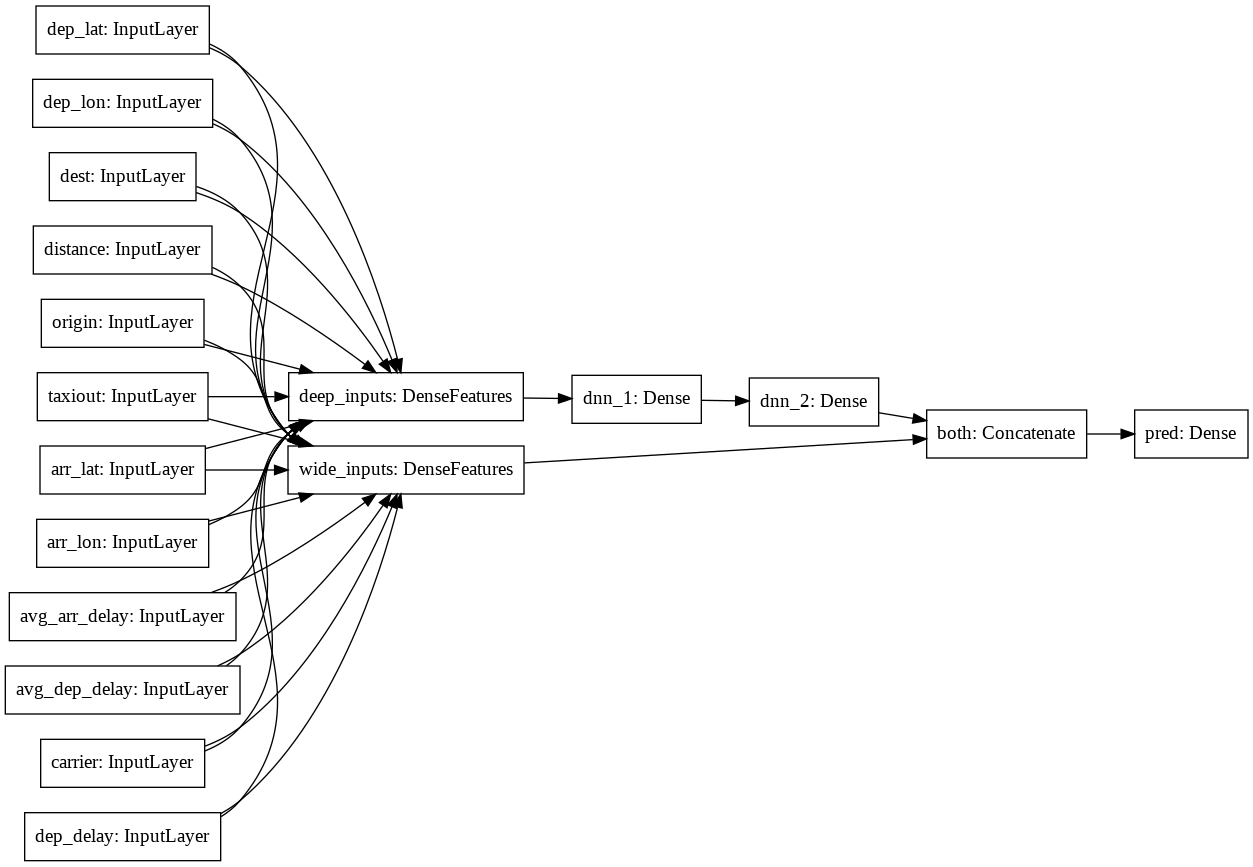

In [29]:
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

In [0]:
import os, json, math, shutil

In [0]:
TRAIN_BATCH_SIZE = 64
#  output_dir='gs://{}/flights/trained_model'.format(BUCKET)
# colab 환경으로 적용 
BUCKET = 'cloud_ml'
output_dir='gc_data/{}'.format(BUCKET)

In [42]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 5   # 기본 3
    epochs = 10
else:
    eval_batch_size = 10000
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
train_dataset = read_dataset(TRAIN_DATA_PATTERN, train_batch_size)
eval_dataset = read_dataset(EVAL_DATA_PATTERN, eval_batch_size, tf.estimator.ModeKeys.EVAL, eval_batch_size*10)

checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset, 
                    validation_data=eval_dataset,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Train for 5 steps, validate for 1000 steps
Epoch 1/10
1/5 [=====>........................] - ETA: 3s - loss: 0.3505 - accuracy: 0.8906
Epoch 00001: saving model to gc_data/cloud_ml/checkpoints/flights.cpt
5/5 [==============================] - 6s 1s/step - loss: 0.3624 - accuracy: 0.8594 - val_loss: 0.3012 - val_accuracy: 0.8888
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 0.3840 - accuracy: 0.7969
Epoch 00002: saving model to gc_data/cloud_ml/checkpoints/flights.cpt
5/5 [==============================] - 5s 954ms/step - loss: 0.3186 - accuracy: 0.8469 - val_loss: 0.2904 - val_accuracy: 0.9124
Epoch 3/10
1/5 [=====>........................] - ETA: 0s - loss: 0.2866 - accuracy: 0.8750
Epoch 00003: saving model to gc_data/cloud_ml/checkpoints/flights.cpt
5/5 [==============================] - 5s 1s/step - loss: 0.2985 - accuracy: 0.8750 - val_loss: 0.2730 - val_accuracy: 0.9247
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.2654 - accuracy: 0.890

In [44]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


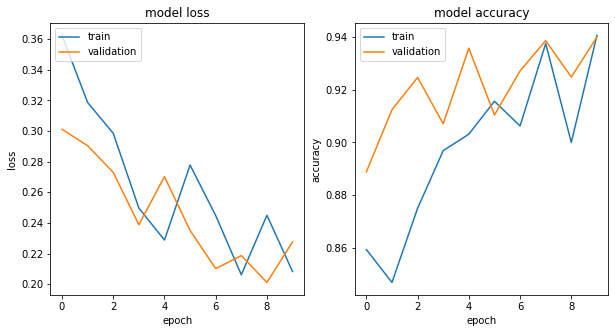

In [45]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

### Export and deploy the trained model

```
output_dir='gs://{}/flights/trained_model'.format(BUCKET)

import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)
```

In [46]:
print(output_dir)

gc_data/cloud_ml


In [43]:
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gc_data/cloud_ml/export/flights_20200317-054559
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: gc_data/cloud_ml/export/flights_20200317-054559/assets
